cuda:0


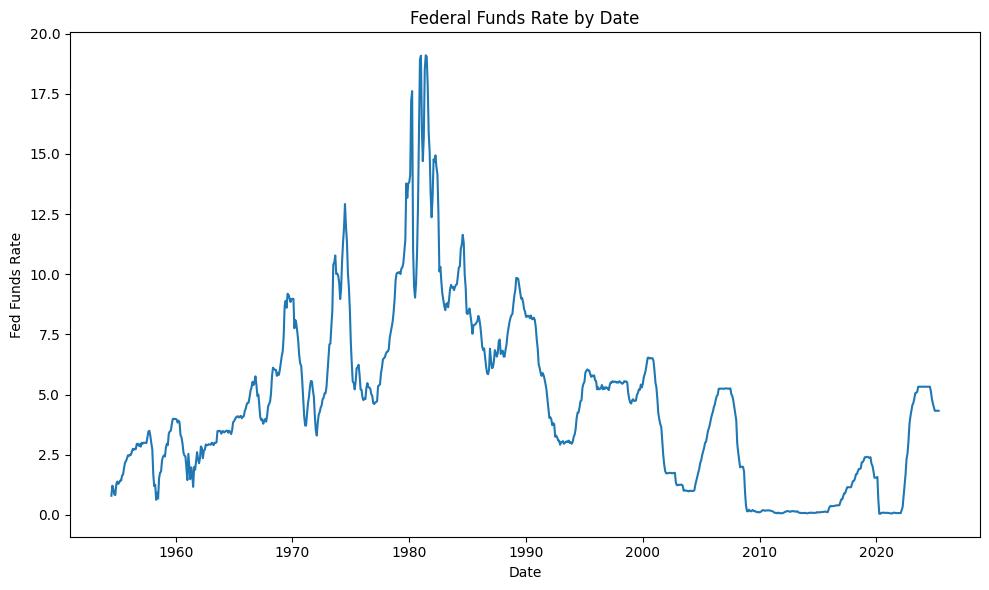

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from fredapi import Fred
from docs.untitled import fred_api_key
import pandas as pd
import fredapi as fr
from sklearn.preprocessing import MinMaxScaler
import numpy as np


fred = fr.Fred(fred_api_key)




device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

"""Interest Rates(Fed Funds Rate) """

ffr = fred.get_series("FEDFUNDS")
ffr.name = "Fed Funds Rate"

data = pd.DataFrame(ffr).dropna()

data = data.reset_index()
data['Date'] = data['index']
data.drop("index",axis=1,inplace=True)
data.head(10)


plt.figure(figsize=(10,6))
sns.lineplot(x=data['Date'],y=data['Fed Funds Rate'])
plt.title("Federal Funds Rate by Date")
plt.savefig("images/federal-funds-rate-date.png")
plt.tight_layout()
plt.show()


In [2]:

training = data.iloc[:,0:1].values



train_split = int(len(training) * .70)
train_data = training[:train_split]
test_data = training[train_split:]


scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

def slider(dataframe, seq_length):
    X, y = [], []
    for i in range(len(dataframe) - seq_length - 1):
        X_ = dataframe[i:(i + seq_length)]
        y_ = dataframe[i + seq_length]
        X.append(X_)
        y.append(y_)
    return np.array(X), np.array(y)

seq_length = 1
X_train, y_train = slider(train_data, seq_length)
X_test,y_test = slider(test_data,seq_length)


X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()





class LSTM(nn.Module):
    def __init__(self,input_size,hidden_size,num_layers,output_size):
        super(LSTM,self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.lstm = nn.LSTM(input_size,hidden_size,num_layers,batch_first=True)
        
        self.fc = nn.Linear(hidden_size,output_size)
        
    def forward(self,X):
        h0 = torch.zeros(self.num_layers,X.size(0),self.hidden_size)
        c0 = torch.zeros(self.num_layers,X.size(0),self.hidden_size)
        out,_ = self.lstm(X,(h0,c0))
        out = self.fc(out[:,-1,:])
        return out



model = LSTM(input_size=1,hidden_size=64,num_layers=1,output_size=1)
optimizer = torch.optim.Adam(model.parameters(),lr=0.002)
loss_fn = nn.MSELoss()
epochs = 500

for epoch in range(epochs):
    y_pred = model(X_train)
    loss = loss_fn(y_pred.float(),y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 1 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rsme = np.sqrt(loss_fn(y_pred,y_train))
        y_pred_test =  model(X_test)
        test_rsme = np.sqrt(loss_fn(y_pred_test,y_test))
        print(f'Epoch: {epoch}; train_RSEM: {train_rsme:.4}; Test RSME: {test_rsme:.4}')

C:\Users\katsa\AppData\Local\Temp\ipykernel_5116\2792477528.py:74: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  train_rsme = np.sqrt(loss_fn(y_pred,y_train))
C:\Users\katsa\AppData\Local\Temp\ipykernel_5116\2792477528.py:76: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  test_rsme = np.sqrt(loss_fn(y_pred_test,y_test))


Epoch: 0; train_RSEM: 0.3773; Test RSME: 0.15
Epoch: 1; train_RSEM: 0.3694; Test RSME: 0.144
Epoch: 2; train_RSEM: 0.3615; Test RSME: 0.1381
Epoch: 3; train_RSEM: 0.3536; Test RSME: 0.1325
Epoch: 4; train_RSEM: 0.3456; Test RSME: 0.1271
Epoch: 5; train_RSEM: 0.3375; Test RSME: 0.122
Epoch: 6; train_RSEM: 0.3294; Test RSME: 0.1171
Epoch: 7; train_RSEM: 0.3212; Test RSME: 0.1127
Epoch: 8; train_RSEM: 0.3129; Test RSME: 0.1087
Epoch: 9; train_RSEM: 0.3046; Test RSME: 0.1052
Epoch: 10; train_RSEM: 0.2961; Test RSME: 0.1024
Epoch: 11; train_RSEM: 0.2876; Test RSME: 0.1002
Epoch: 12; train_RSEM: 0.2789; Test RSME: 0.09887
Epoch: 13; train_RSEM: 0.2703; Test RSME: 0.09843
Epoch: 14; train_RSEM: 0.2615; Test RSME: 0.09895
Epoch: 15; train_RSEM: 0.2528; Test RSME: 0.1005
Epoch: 16; train_RSEM: 0.244; Test RSME: 0.103
Epoch: 17; train_RSEM: 0.2353; Test RSME: 0.1065
Epoch: 18; train_RSEM: 0.2267; Test RSME: 0.111
Epoch: 19; train_RSEM: 0.2182; Test RSME: 0.1164
Epoch: 20; train_RSEM: 0.2099; Tes

In [3]:

with torch.no_grad():
    pred = model(X_test)
    pred_np = pred.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    pred_rescaled = scaler.inverse_transform(pred_np)
    actual_rescaled = scaler.inverse_transform(y_test_np)



test_dates = data.iloc[train_split + seq_length: -1]['Date'].reset_index(drop=True)


comparison_df = pd.DataFrame({
    "Date": test_dates,
    "Actual Interest Rate": actual_rescaled.flatten(),
    "Predicted Interest Rate": pred_rescaled.flatten()
})

print(comparison_df.head(20))
print(comparison_df.tail(20))

         Date  Actual Interest Rate  Predicted Interest Rate
0  2004-03-01                  1.00                 1.255862
1  2004-04-01                  1.00                 1.246838
2  2004-05-01                  1.00                 1.246838
3  2004-06-01                  1.03                 1.246838
4  2004-07-01                  1.26                 1.273913
5  2004-08-01                  1.43                 1.481956
6  2004-09-01                  1.61                 1.636256
7  2004-10-01                  1.76                 1.800118
8  2004-11-01                  1.93                 1.937050
9  2004-12-01                  2.16                 2.092651
10 2005-01-01                  2.28                 2.303862
11 2005-02-01                  2.50                 2.414372
12 2005-03-01                  2.63                 2.617525
13 2005-04-01                  2.79                 2.737904
14 2005-05-01                  3.00                 2.886398
15 2005-06-01           

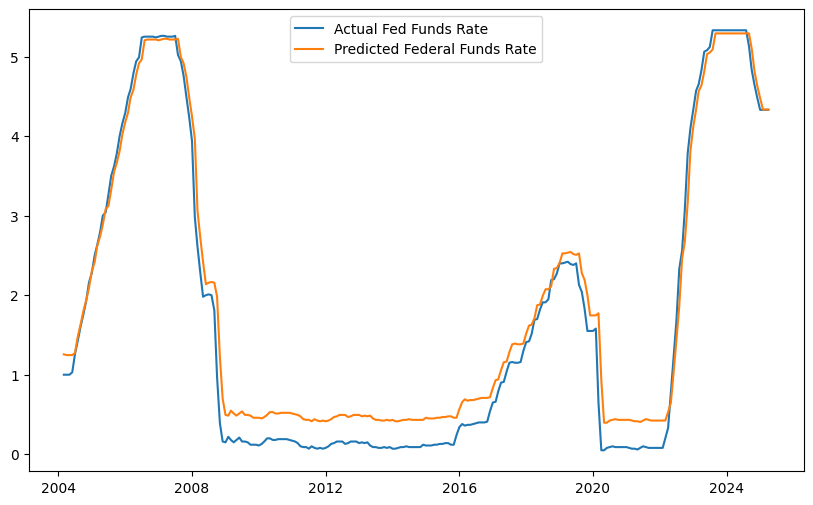

In [4]:
plt.figure(figsize=(10,6))
plt.plot(comparison_df['Date'],comparison_df["Actual Interest Rate"],label="Actual Fed Funds Rate")
plt.plot(comparison_df['Date'],comparison_df['Predicted Interest Rate'],label="Predicted Federal Funds Rate")
plt.legend()
plt.savefig("images/predicted-vs-actual.png")
plt.show()
